## Required Data
- `pip install git+https://github.com/facebookresearch/segment-anything.git`
- `wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth`

## Import Required Packages

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True


## Basic Function

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

## Load Random Image from PURE Dataset

- There are 10 subjects. Each subjects has 6 recordings. Directory name format (xx-yy) where xx is the subject number and yy is the recording number.
- There is no `06-02`

In [3]:
puredt_path = '/mnt/disk2/PURE'

In [4]:
# random subject from 1 - 10
ran_sub = random.randint(1, 10)
ran_rec = random.randint(1, 6)

# change the format into two digits
folder_name = str(ran_sub).zfill(2) + '-' + str(ran_rec).zfill(2)
print(f"Folder name: {folder_name}")

# populate the `png` files
png_files = os.listdir(os.path.join(puredt_path, folder_name))
print(f"Total number of files: {len(png_files)}")

Folder name: 09-01
Total number of files: 1965


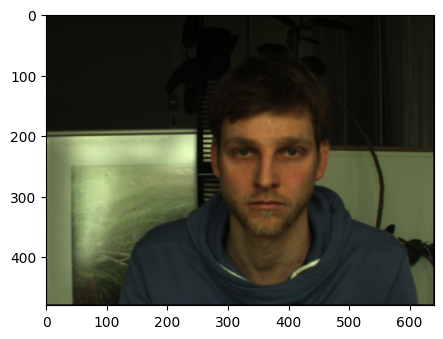

In [5]:
# select a random image
ran_img = random.choice(png_files)
img = cv2.imread(os.path.join(puredt_path, folder_name, ran_img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(img); plt.axis('on'); plt.show()

## Selecting Object with SAM

Load the predictor

In [6]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

predit the image

In [7]:
predictor.set_image(img)

select input point

In [8]:
input_point = np.array([[350, 185]]) # match it with the object on the image
input_label = np.array([1]) # 0 is for background

visualize input point location

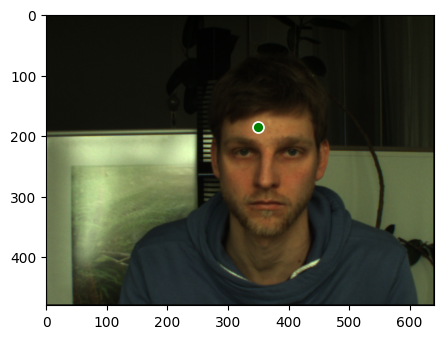

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(img)
show_points(input_point, input_label, plt.gca(), marker_size=250)
plt.axis('on')
plt.show()

Predict the segment

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

visualize the segment

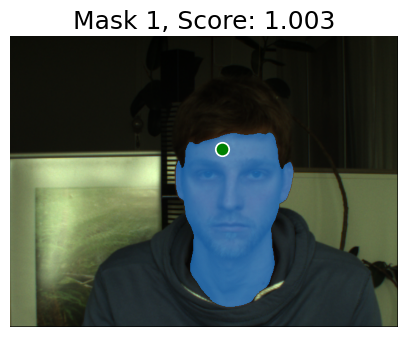

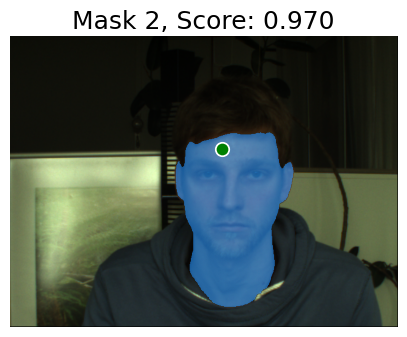

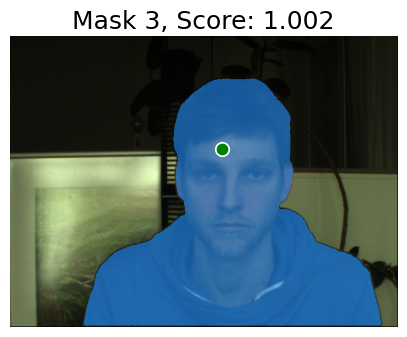

In [11]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

enhance the quality by defining multi-point

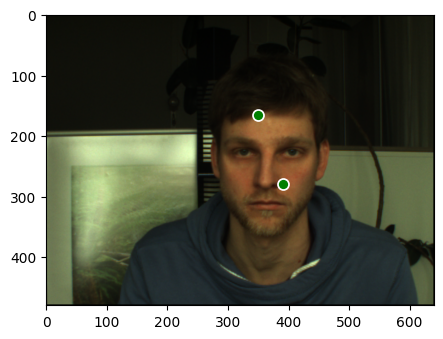

In [12]:
input_point = np.array([[350, 165], [390, 280]]) # match it with the object on the image
input_label = np.array([1, 1]) # 0 is for background

plt.figure(figsize=(5,5))
plt.imshow(img)
show_points(input_point, input_label, plt.gca(), marker_size=250)
plt.axis('on')
plt.show()

re-estimate

In [13]:
mask_input = logits[np.argmax(scores), :, :]

In [14]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    # mask_input=mask_input[None, :, :],
    multimask_output=False,
)

preview

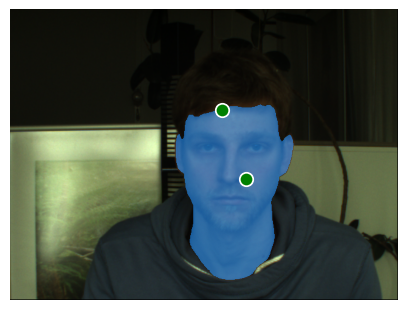

: 

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(img)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 